<a href="https://colab.research.google.com/github/kelson-martins/deep-learning-cnn/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data1.h5  gdrive  sample_data
(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 17)                4456465   
Total params: 4,458,257
Trainable params: 4,458,257
Non-trainable params: 0
_________________________________________________________________
None
Training network...
Train on 1020 samples, validate on 340 samples
Epoch 1/60
1020/1020 [==============================] - 1s 1ms/sample - loss: 2.6165 - ac

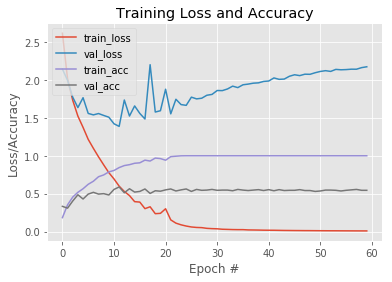

In [0]:

#from google.colab import drive 
 
#drive.mount('/content/gdrive')

#!unzip "/content/gdrive/My Drive/miscellaneous/data1-2.h5.zip"

!ls

import numpy as np 
import h5py



def build(width, height, depth, classes):

  # initialize the model along with the input shape to be
  # "channels last"
  model = tf.keras.Sequential()

  inputShape = (height, width, depth)
  
  # define the first CONV => RELU layer
  model.add(tf.keras.layers.Conv2D (64, (3, 3), padding="same",input_shape=inputShape, activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # softmax classifier
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(classes, activation='softmax'))

  return model

def loadDataH5():
  
  with h5py.File('data1.h5','r') as hf:
    trainX = np.array(hf.get('trainX')) 
    trainY = np.array(hf.get('trainY')) 
    valX = np.array(hf.get('valX')) 
    valY = np.array(hf.get('valY')) 
    print (trainX.shape,trainY.shape) 
    print (valX.shape,valY.shape)
    
    return trainX, trainY, valX, valY
  

NUM_EPOCHS = 60

# load the training and testing data, then scale it into the
trainX, trainY, testX, testY = loadDataH5()

# initialize the optimizer and model
print("Compiling model...")
opt = tf.keras.optimizers.SGD(lr=0.01)
model = build(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("Training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),batch_size=32, epochs=NUM_EPOCHS)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 60), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
